# Data cleaning and EDA for Santender dataset

## Table of Contents
1. Problem Statement
2. Data source
3. Data Cleaning
4. Data exploration
5. Feature selection and engineering
6. Finding key features
7. Check for dataset imbalance and resolve if applicable

## 1) Problem Statement

When it comes to advertising multiple products to customers a significant problem arises. Which product should we prioritise showing to customers? Given the frequency of advertisements in our daily lives the atention span we can afford to these advertisements is fleeting at best. A poor choice of product to show our customers can lead to disastrous consequences. Not only is this a waste of advertising funds, the customer can also be annoyed by the irrelevant advertisements and take action to avoid them, either by ignoring them or blocking off our marketing channel if possible, such as muting our email advertisements. Even if a customer is potentially interested in multiple products, we should prioritise the product they want the most to maximise the likelyhood that they would do business with us, and possibly stay as a recurring customer.

Fortunately, banks have access to a large amount of data from their customers which if utilised properly, can be a powerful asset to make data driven decisions and signifcantly boost the success rate of marketing campaigns. However another problem appears: the potential of data is difficult to harness due to its cryptic and indirect nature. It is difficult to understand how seemingly irrelevant pieces of information can suggest that a customer is more receptive to a particular product.

In this part of the project we will address the question of "Which product should we prioritise showing to customers" by creating a recommendation system that is driven by data. To do this we will go through how bank data can be cleaned, processed and finally utilised to develop an intepretable machine learning model that can make the data driven recommendations.

## 2) Data source
The dataset is acquired from Santander Bank, originally founded in Spain as Banco Santander, is a major global financial institution headquartered in Madrid, Spain. It operates in numerous countries across Europe, North and South America, and parts of Asia, and is known for a broad range of banking services. 

While the dataset does not contain information on any real customer due to privacy concerns, the data is still representative of typical customers. It contains information of the (hypothetical) customer such as their age, household gross income, martital status and so on. This data once prepared will provide the crucial clues of the customer's financial and social situation needed in order to develop a machine learning model that can make accurate predictions of what products we should recommend to customers.

The dataset is in spanish and hence will need to be translated to english for intepretability.

### 2.1) Imports and Data Ingestion

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statistics import median
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder
from sklearn.manifold import TSNE


In [ ]:
## Set the names of the files to clean and the name of the cleaned files here:
raw_data_file = "recodataset.csv"
clean_train = "data/clean_train_reco.csv"
clean_test = "data/clean_test_reco.csv"

#Number below determines size of cleaned dataset, which is this number * number of products * 2
#in this case dataset size is about 15000*8 = 120000 rows
number_of_each_class = 15000 

Read in raw data into df

In [3]:
print("Current Working Directory:", os.getcwd()) 

# Define file paths for training and testing data
raw_file_path = os.path.join("../..", "data", raw_data_file)  

# Print the paths to verify
print("Raw Data Path:", raw_file_path)

# Read the raw CSV file
df = pd.read_csv(raw_file_path)

Current Working Directory: /Users/carlychinsekyi/Downloads/OpenAYEye/notebook/reco_system
Raw Data Path: ../../data/recodataset.csv


## 3) Data cleaning and simplification

Santender bank offers many products, 24 products. We decided to simplify the problem by focusing on only 4 products in order to make the explanations and diagrams that will be used later easy to digest. As we will show later, the steps we have taken can be done for as many products as needed.

The first step to preparing the data for machine learning (ML) use is data cleaning. This involves:
1. Renaming the columns of the data to english for readability
2. Reducing the number of products from 24 to 4 by grouping them into 4 broadly defined products
3. Handling missing values
4. Combining columns to get more useful columns

### 3.1) Renaming columns which have spanish names to english for readability

In [4]:
output_file_path = clean_train  # output training CSV file

# Define the mapping of original Spanish column names to English column names
column_mapping = {
    "fecha_dato": "report_date",
    "ncodpers": "customer_id",
    "ind_empleado": "employee_index",
    "pais_residencia": "country_residence",
    "sexo": "gender",
    "age": "age",
    "fecha_alta": "contract_start_date",
    "ind_nuevo": "new_customer_index",
    "antiguedad": "seniority_months",
    "indrel": "primary_customer_status",
    "ult_fec_cli_1t": "last_primary_customer_date",
    "indrel_1mes": "customer_type_start_month",
    "tiprel_1mes": "customer_relation_type",
    "indresi": "residence_index",
    "indext": "foreigner_index",
    "conyuemp": "spouse_employee_index",
    "canal_entrada": "join_channel",
    "indfall": "deceased_index",
    "tipodom": "address_type",
    "cod_prov": "province_code",
    "nomprov": "province_name",
    "ind_actividad_cliente": "activity_index",
    "renta": "gross_income",
    "segmento": "customer_segment",
    "ind_ahor_fin_ult1": "saving_account",
    "ind_aval_fin_ult1": "guarantee",
    "ind_cco_fin_ult1": "current_account",
    "ind_cder_fin_ult1": "derivada_account",
    "ind_cno_fin_ult1": "payroll_account",
    "ind_ctju_fin_ult1": "junior_account",
    "ind_ctma_fin_ult1": "more_particular_account",
    "ind_ctop_fin_ult1": "particular_account",
    "ind_ctpp_fin_ult1": "particular_plus_account",
    "ind_deco_fin_ult1": "short_term_deposits",
    "ind_deme_fin_ult1": "medium_term_deposits",
    "ind_dela_fin_ult1": "long_term_deposits",
    "ind_ecue_fin_ult1": "e_account",
    "ind_fond_fin_ult1": "funds",
    "ind_hip_fin_ult1": "mortgage",
    "ind_plan_fin_ult1": "pensions",
    "ind_pres_fin_ult1": "loans",
    "ind_reca_fin_ult1": "taxes",
    "ind_tjcr_fin_ult1": "credit_card",
    "ind_valo_fin_ult1": "securities",
    "ind_viv_fin_ult1": "home_account",
    "ind_nomina_ult1": "payroll",
    "ind_nom_pens_ult1": "pensions_payments",
    "ind_recibo_ult1": "direct_debit"
}
# Rename the columns to english
df.rename(columns=column_mapping, inplace=True)

### 3.2) Grouping the 24 bank products into 4 products
The 4 product types that encompass all the products have are:
- fixed-deposits
- loan
- accounts
- credit and debit cards

If we wanted to include all 24 products in our recommendation system we simply have to skip this step

In [5]:
# Define new column names
fixed_deposits_col = 'fixed_deposits'
loan_col = 'loan'
credit_card_debit_card_col = 'credit_card_debit_card'
account_col = 'account'

# Check and create a new column for fixed deposits, if it doesn't exist
if fixed_deposits_col not in df.columns:
    deposit_columns = [
        "short_term_deposits",  # ind_deco_fin_ult1
        "medium_term_deposits",  # ind_deme_fin_ult1
        "long_term_deposits"    # ind_dela_fin_ult1
    ]
    df[fixed_deposits_col] = df[deposit_columns].any(axis=1).astype(int)

# Check and create a new column for loans, if it doesn't exist
if loan_col not in df.columns:
    loan_columns = [
        "loans",                # ind_pres_fin_ult1
        "pensions"             # ind_plan_fin_ult1
    ]
    df[loan_col] = df[loan_columns].any(axis=1).astype(int)

# Check and create a new column for credit and debit cards, if it doesn't exist
if credit_card_debit_card_col not in df.columns:
    credit_card_columns = [
        "credit_card",         # ind_tjcr_fin_ult1
        "direct_debit"        # ind_recibo_ult1
    ]
    df[credit_card_debit_card_col] = df[credit_card_columns].any(axis=1).astype(int)

# Check and create a new column for all accounts combined, if it doesn't exist
if account_col not in df.columns:
    account_columns = [
        "saving_account",      # ind_ahor_fin_ult1
        "current_account",     # ind_cco_fin_ult1
        "derivada_account",    # ind_cder_fin_ult1
        "payroll_account",     # ind_cno_fin_ult1
        "junior_account",      # ind_ctju_fin_ult1
        "more_particular_account",  # ind_ctma_fin_ult1
        "particular_account",   # ind_ctop_fin_ult1
        "particular_plus_account", # ind_ctpp_fin_ult1
        "e_account",           # ind_ecue_fin_ult1
        "funds",               # ind_fond_fin_ult1
        "home_account",        # ind_viv_fin_ult1
    ]
    df[account_col] = df[account_columns].any(axis=1).astype(int)

# Remove these columns as they have been grouped into the 4 larger categories of products
columns_to_drop = [
    'saving_account', 'guarantee', 'current_account', 'derivada_account', 'payroll_account', 
    'junior_account', 'more_particular_account', 'particular_account', 'particular_plus_account', 
    'short_term_deposits', 'medium_term_deposits', 'long_term_deposits', 'e_account', 'funds', 
    'mortgage', 'pensions', 'loans', 'taxes', 'credit_card', 'securities', 'home_account', 
    'payroll', 'pensions_payments', 'direct_debit', 'employee_index'
]

# Drop the columns if they exist
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

### 3.3) Handling missing data
Before explaining how missing data is handled we will give a brief explanation of how data is stored.
Data is organised by rows and columns, each row of data is an entry pertaining to one customer. On the other hand, each column represents one detail of all customers. This is an example of a data table, note that the first row of a data table usually contains the title of each column
| Name    | Age | Married |
|---------|-----|---------|
| Alice   | 30  | Yes     |
| Bob     | 25  | No      |



When it comes to missing data, we have to make a choice based on what kind of data is in that column of data:
1. If the column is binary (either 0 or 1) we can replace the missing value with either 0 or 1, based on contextual information
2. If the column is numerical we can set the missing value to be the median of all values in that column
3. We can drop the row with the missing value if there are very few of such rows and the data column is not a crucial feature

"Gross income" and "age" are crucial features in determining a customer's economic status, which influences their likelihood of purchasing a product. Additionally, dropping rows without values in this field is not justifiable, as we cannot compel customers to disclose this information in real life, and excluding those who refuse to do so will skew the data we have of customers. Option 1 and 3 have been eliminated. Therefore, we will be imputing the median value for the missing values in this column.

In [6]:
## Replace missing values in gross income and age with median of distribution
count = df['gross_income'].isna().sum()
df['gross_income'] = df['gross_income'].fillna(df['gross_income'].median())

df['age'] = pd.to_numeric(df['age'].replace(' NA', None), errors='coerce')
med_age = df['age'].median()
df['age'] = df['age'].fillna(med_age).astype(int)


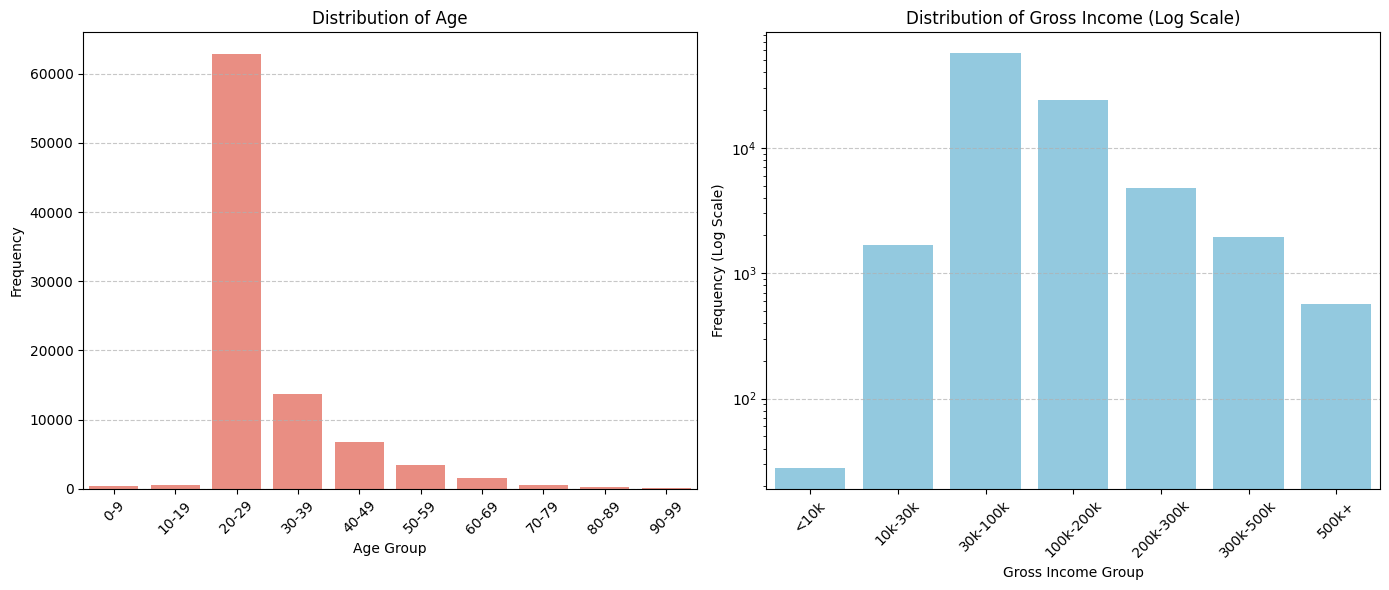

In [7]:

# Create a temporary DataFrame for age groups
temp_age_df = df[['age']].copy()
# Create age groups in 10-year intervals
age_bins = range(0, 101, 10)  # 0-100 years
age_labels = [f"{i}-{i+9}" for i in age_bins[:-1]]  # e.g., '0-9', '10-19', ..., '90-99'

temp_age_df['age_group'] = pd.cut(temp_age_df['age'], bins=age_bins, labels=age_labels, right=False)

# Count the number of occurrences in each age group
age_counts = temp_age_df['age_group'].value_counts().reindex(age_labels)

# Set up the plotting area
plt.figure(figsize=(14, 6))

# Bar chart for age with 10-year intervals
plt.subplot(1, 2, 1)
sns.barplot(x=age_counts.index, y=age_counts.values, color='salmon')
plt.title('Distribution of Age')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Create a temporary DataFrame for income groups
temp_income_df = df[['gross_income']].copy()
# Create bins for gross income
income_bins = [0, 10000, 30000, 100000, 200000, 300000, 500000, 1000000]
income_labels = ['<10k', '10k-30k', '30k-100k', '100k-200k', '200k-300k', '300k-500k', '500k+']
temp_income_df['income_group'] = pd.cut(temp_income_df['gross_income'], bins=income_bins, labels=income_labels, right=False)

# Count the number of occurrences in each income group
income_counts = temp_income_df['income_group'].value_counts().reindex(income_labels)

# Bar plot for gross income with log scale
plt.subplot(1, 2, 2)
sns.barplot(x=income_counts.index, y=income_counts.values, color='skyblue')
plt.yscale('log')  # Set y-axis to log scale
plt.title('Distribution of Gross Income (Log Scale)')
plt.xlabel('Gross Income Group')
plt.ylabel('Frequency (Log Scale)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()





### Analysising distribution of gross_income and age
Majority of the customers are between 20-29 years of age and the mode of income is between 30-100k. This suggests that a large number of customers at santender are young adults who just started working. We should prioritise products that appeal to this group of people.

/var/folders/pg/k1hh45tx53v5c4hp65ntyjtc0000gn/T/ipykernel_17763/2983224275.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_gross_income = temp_df.groupby('age_group')['gross_income'].mean().reset_index()


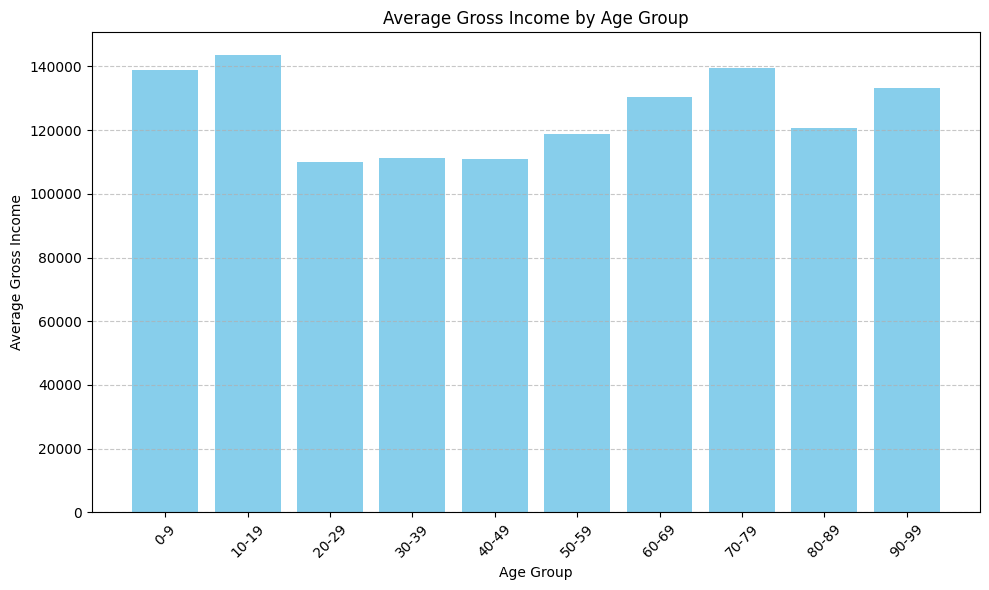

In [8]:
# Create age groups (10-year intervals) in a separate DataFrame
bins = range(0, 101, 10)  # Adjust the upper limit as needed
labels = [f"{i}-{i+9}" for i in bins[:-1]]  # e.g., ['0-9', '10-19', ..., '90-99']

# Create a temporary DataFrame for age groups and gross income
temp_df = df[['age', 'gross_income']].copy()
temp_df['age_group'] = pd.cut(temp_df['age'], bins=bins, labels=labels, right=False)

# Calculate the average gross income for each age group
avg_gross_income = temp_df.groupby('age_group')['gross_income'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(avg_gross_income['age_group'], avg_gross_income['gross_income'], color='skyblue')
plt.title('Average Gross Income by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Gross Income')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Observations from average income to age group plot
According to the plot of average gross_income to age group, the gross_income is very evenly distributed. We noticed that the income of people aged 0-9 is roughly equal to the other age groups which was very odd. After further research, we found that this column "gross_income" refers to gross income of the household rather than the individual's gross_income. The higher gross_income of age groups 0-9 and 10-19 implies that households with higher gross income are more likely to have children.

/var/folders/pg/k1hh45tx53v5c4hp65ntyjtc0000gn/T/ipykernel_17763/3312318494.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


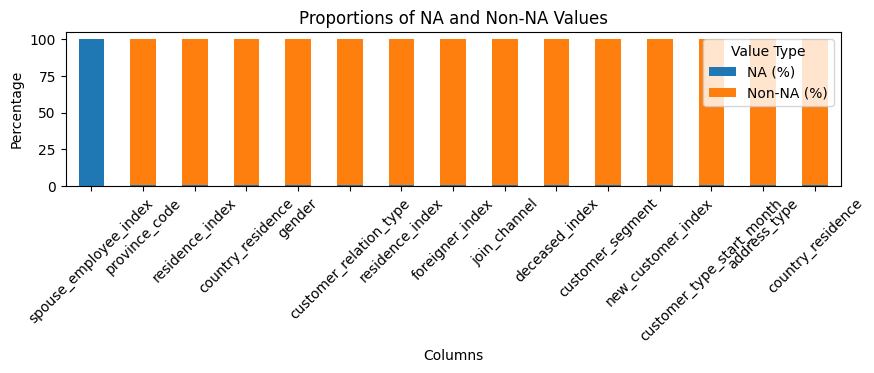

In [9]:
columns_with_na = [
    'spouse_employee_index',
    'province_code', 
    'residence_index',
    'country_residence', 
    'gender', 
    'customer_relation_type', 
    'residence_index', 
    'foreigner_index', 
    'join_channel', 
    'deceased_index', 
    'customer_segment', 
    'new_customer_index',
    'customer_type_start_month',
    'address_type',
    'country_residence'
]

# Calculate the proportion of NA and non-NA values
na_counts = df[columns_with_na].isna().sum()
total_counts = df[columns_with_na].shape[0]
non_na_counts = total_counts - na_counts

# Calculate proportions
na_proportions = na_counts / total_counts * 100
non_na_proportions = non_na_counts / total_counts * 100

# Create a DataFrame for proportions
proportions = pd.DataFrame({
    'NA (%)': na_proportions,
    'Non-NA (%)': non_na_proportions
})

# Plotting
proportions.plot(kind='bar', stacked=True, figsize=(10, 2))
plt.title('Proportions of NA and Non-NA Values')
plt.xlabel('Columns')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Value Type')
plt.tight_layout()
plt.show()


### Handling the rest of the missing values
The spouse_employee_index, which is whether the customer is a spouse of an employee in santender, has many missing values. Since there should be many more customers than employees in santender, we can assume that a person is very unlikely to be a spouse of an employee at santender. Hence we will replace any missing values of spouse_employee_index to 0.
The other columns have very few missing values, so we remove any rows with missing values in these columns

In [10]:
# Replace NA values in 'spouse_employee_index' with 0
df['spouse_employee_index'].fillna(0, inplace=True)
# Drop rows with NA values in the specified columns
df = df.dropna(subset=columns_with_na)

/var/folders/pg/k1hh45tx53v5c4hp65ntyjtc0000gn/T/ipykernel_17763/514752935.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['spouse_employee_index'].fillna(0, inplace=True)


#### Strip leading and trailing spaces from string columns

In [11]:
def strip_spaces(column):
    if column.dtype == 'object':  # Check if the column is of string type
        return column.str.strip()  # Strip leading and trailing spaces
    return column

# Apply the strip_spaces function to all columns in the DataFrame
df = df.apply(strip_spaces)

# Remove leading/trailing whitespace of seniority_months column and convert to numeric
df['seniority_months'] = pd.to_numeric(df['seniority_months'].str.strip(), errors='coerce')

### 3.4) Combining columns
Report_date and contract_start_date do not provide much meaningful information on their own, so we combined them into contract_length by taking the difference between the two dates, which is a more insightful numerical feature

In [12]:
date_columns = ['report_date', 'contract_start_date']  

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Calculate the difference in days
df['contract_length'] = (df['report_date'] - df['contract_start_date']).dt.days

# Insert 'contract_length' in the same spot as 'contract_start_date'
start_date_index = df.columns.get_loc('contract_start_date')
df.insert(start_date_index, 'contract_length', df.pop('contract_length'))

# Drop the original 'contract_start_date' and 'report_date' columns
df = df.drop(['contract_start_date', 'report_date', 'customer_id'], axis='columns')


## 4) Data exploration

Now that our data has been cleaned, we can begin visualising and gathering insights from the data. We can also narrow down which data columns are useful should be kept for machine learning and which are redundant should be discarded. 

This section involves a few parts:
1. Correlation matrix to find redundant data columns
2. Counting the number of unique classes in each categorical data column, which is important as we will need to convert these columns into numerical columns
3. Plotting a graphs of a few columns to gather insight

### 4.1) Correlation matrix

We use a correlation matrix to determine which columns to remove, a correlation matrix determines how strongly related any two columns are to each other, in other words how similar the patterns of two columns of data are. By finding feature columns that are strongly correlated to each other we can remove redundant columns. For example the columns province_name and province_code refer to the same province and hence it is pointless for a machine learning model to use both columns. In fact it is harmful to the model as it adds noise to the data and leads to poorer model performance.

From the correlation matrix we found that the following 4 features: customer_type_start_month, spouse_employee_index, address_type, and country_residence are blank. This occured after removing all missing values which implies these columns only have one value and hence useless columns. 
In addition: 
primary_customer_status and last_primary_customer_date are highly correlated with 0.9 
activity index is correlated to customer_relation_type with -0.8
province_code and province_name are also highly correlated at 0.9 
seniority_months and contract_length are correlated at 1.0

/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


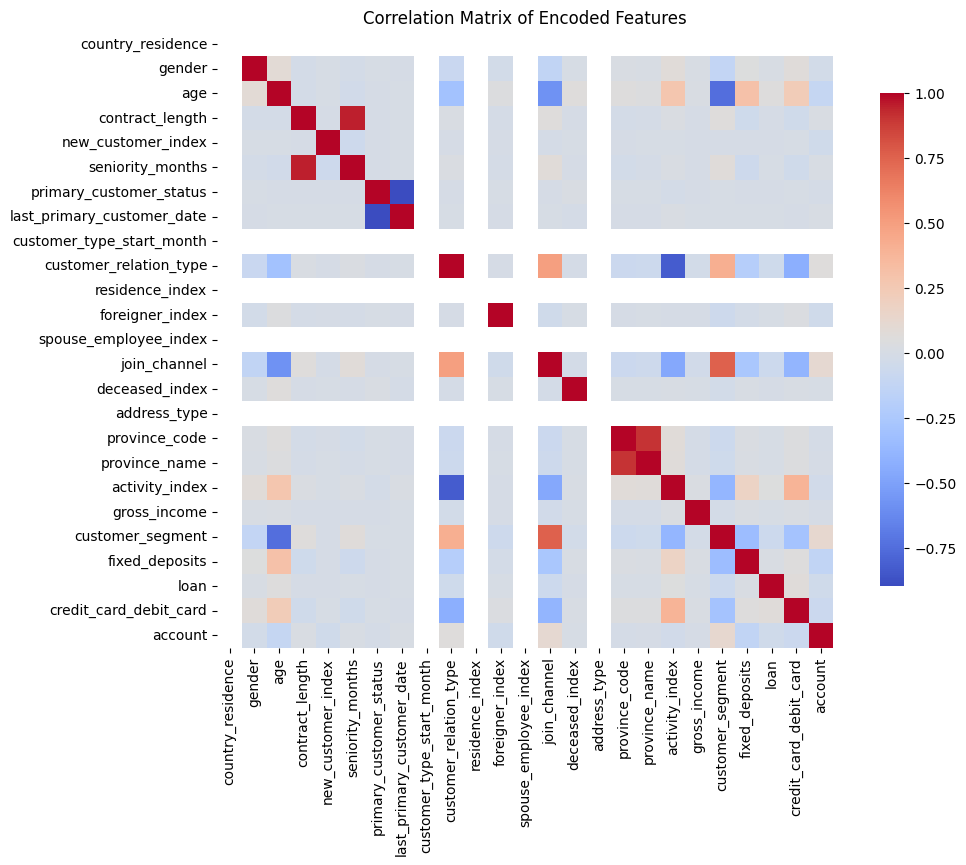

In [13]:
# Create a copy of the DataFrame to work with for encoding
encoded_df = df.copy()

# Identify categorical columns for label encoding
categorical_columns = encoded_df.select_dtypes(include=['category', 'object']).columns.tolist()

# Apply Label Encoder to categorical columns in encoded_df
label_encoder = LabelEncoder()
for col in categorical_columns:
    encoded_df[col] = label_encoder.fit_transform(encoded_df[col])

# Calculate the correlation matrix on encoded_df
correlation_matrix = encoded_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Encoded Features')
plt.show()



In [14]:
## We now check that the columns mentioned earlier do in fact only have 1 value
# List of columns to check
columns_to_check = ['customer_type_start_month', 'spouse_employee_index', 'address_type', 'country_residence']

# Retrieve and print unique values for each specified column
unique_values = {col: df[col].unique() for col in columns_to_check}
for col, values in unique_values.items():
    print(f"Unique values in '{col}': {values}")


Unique values in 'customer_type_start_month': [1.]
Unique values in 'spouse_employee_index': [0.]
Unique values in 'address_type': [1.]
Unique values in 'country_residence': ['ES']


### 4.2) Counting number of unique classes
We will utilize SMOTE and logistic regression in our project, and this will be explained later section. This requires our dataset to contain only numerical columns, hence we need to encode categorical variables. For each unique class in a categorical column, a new binary column will be created. 
For example, if a size column with 6 unique classes (S, M, L, XL, XXL, XXXL) is one hot encoded it will create 6 new binary columns: S, M, L, XL, XXL, XXXL each having a value of 0 or 1 to indicate if that is the value contained in the original column.

We wish to minimize the number of new columns created to reduce dimensionality, enhance training efficiency, and avoid overfitting. To achieve this, we will identify features with the most unique classes and consolidate those categories to lower their count.

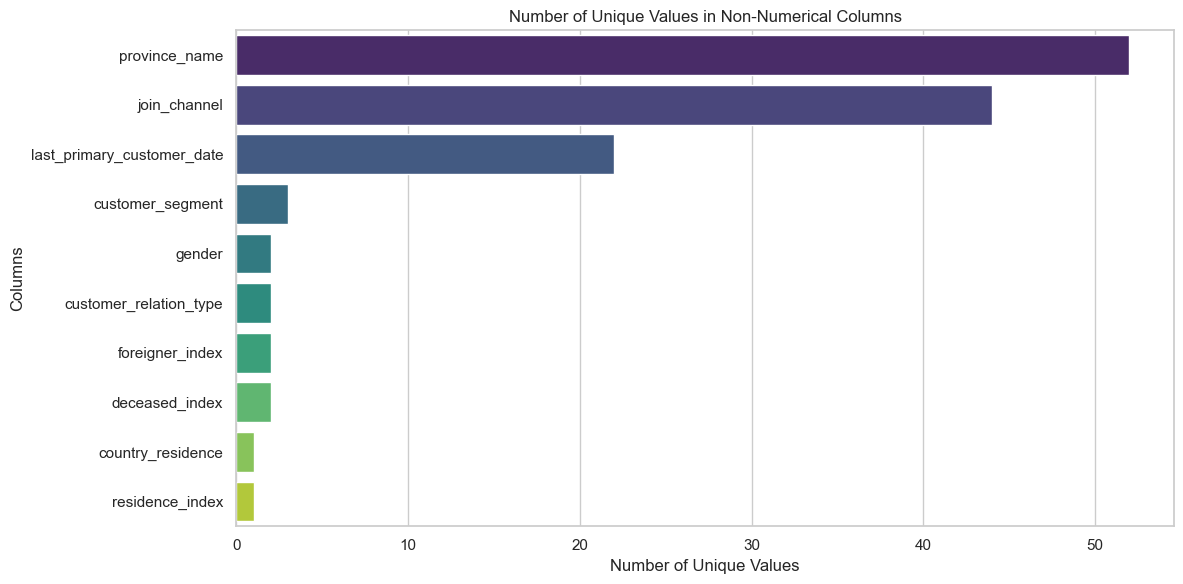

In [15]:
# List all non-numerical columns in the DataFrame
non_numerical_columns = df.select_dtypes(exclude=['number']).columns.tolist()

# Calculate the number of unique values for each non-numerical column
unique_counts = {col: df[col].nunique() for col in non_numerical_columns}

# Create a DataFrame from the unique counts
unique_counts_df = pd.DataFrame(list(unique_counts.items()), columns=['Column', 'Unique Count'])

# Sort the DataFrame by 'Unique Count' in descending order
unique_counts_df = unique_counts_df.sort_values(by='Unique Count', ascending=False)

# Set the style for the plots
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Unique Count', y='Column', data=unique_counts_df, palette='viridis')

plt.title('Number of Unique Values in Non-Numerical Columns')
plt.xlabel('Number of Unique Values')
plt.ylabel('Columns')
plt.tight_layout()
plt.show()


### Grouping values in specific columns with large numbers of unique classes
We will reduce the number of classes in province_name by grouping the provinces into 5 regions of spain, namely north, south, east, west, and central. This will be done in the next section.

Next, there are many unique classes in join_channel, but its values are in 3 letter codes such as KAB or KFF. This combined with the fact that these are in a spanish context makes it hard to decipher accurately what these codes means. We have made an attempt to translate it and noticed the join channels can vary widely from "hospital partnership" to "career expo". We hence decided not to group the values in this column as knowing which specific channel a customer joined through could be crucial information on what product they would prefer.  

Finally the column last_primary_customer_date will be removed in the next step as it is highly correlated with another column.

### 4.3) Various plots to visualise data

In [16]:
print("WIP, make some plots if i have time")

WIP, make some plots if i have time


## 5) Feature selection and engineering

This section involves:
1. Dropping the redundant columns
2. one hot encoding for categorical data  

### 5.1) Dropping redundant columns
After exploring the data in section 4.1, we decided to drop the columns:

'last_primary_customer_date',
'activity_index',
'province_code',
'spouse_employee_index',
'address_type',
'seniority_months'

In [17]:
columns_to_drop = [
    'last_primary_customer_date',
    'activity_index',
    'province_code',
    'spouse_employee_index',
    'address_type',
    'seniority_months'
]

# Drop columns if they exist in the DataFrame
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

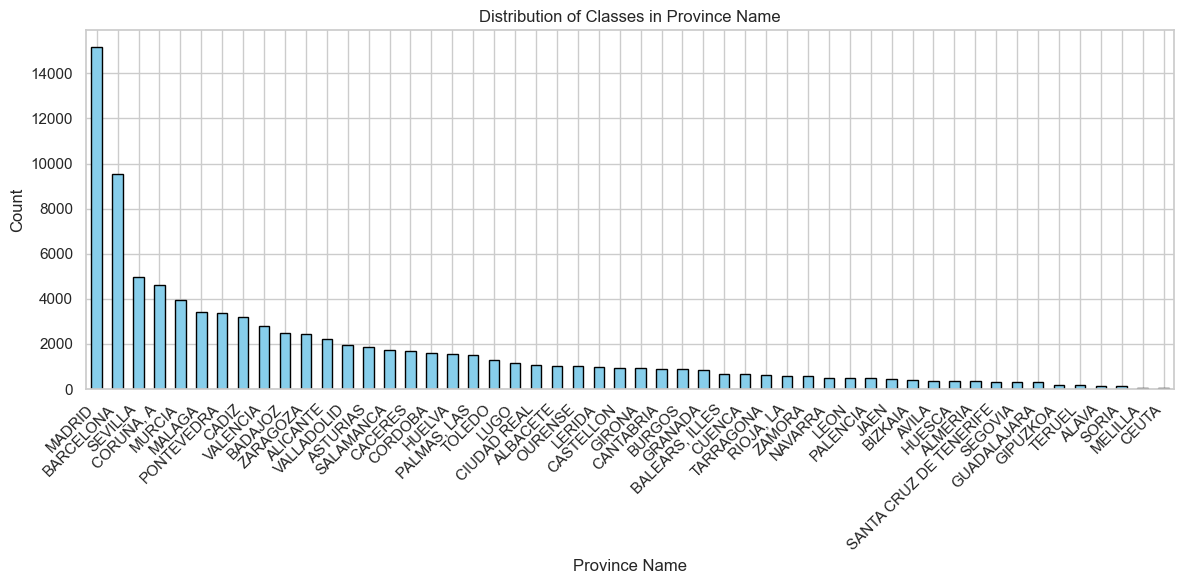

In [18]:
# Calculate the counts for each category in 'province_name'
province_counts = df['province_name'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
province_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Classes in Province Name')
plt.xlabel('Province Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.tight_layout()
plt.show()


Checking the distribution of customers in the different provinces. We will be grouping them into 5 regions so we have to ensure the distribution is not too skewed. The most populated province is Madrid and Barcelonia, madrid is in the central and barcelonia is in the east


#### Regrouping province into 5 regions

In [19]:
# Changing province name to regions so less columns created via one hot encoding
region = []
for province in df['province_name']:
    if province in ['CIUDAD REAL', 'SALAMANCA', 'TOLEDO', 'SEGOVIA', 'MADRID', 'GUADALAJARA', 'ALBACETE', 'SORIA', 'CUENCA', 'AVILA']:
        region.append("CENTRAL")
    elif province in ['ALAVA', 'GIPUZKOA', 'PALENCIA', 'BURGOS', 'NAVARRA', 'CANTABRIA', 'BIZKAIA', 'RIOJA, LA', 'ZARAGOZA', 'TARRAGONA', 'LERIDA', 'HUESCA']:
        region.append("NORTH")
    elif province in ['CADIZ', 'JAEN', 'SEVILLA', 'PALMAS, LAS', 'CORDOBA', 'GRANADA', 'SANTA CRUZ DE TENERIFE', 'MELILLA', 'CEUTA', 'MALAGA']:
        region.append("SOUTH")
    elif province in ['VALENCIA', 'TERUEL', 'BALEARS, ILLES', 'CASTELLON', 'ALICANTE', 'MURCIA', 'ALMERIA', 'BARCELONA', 'GIRONA']:
        region.append("EAST")
    elif province in ['ZAMORA', 'CACERES', 'HUELVA', 'BADAJOZ', 'ASTURIAS', 'LEON', 'LUGO', 'CORUÑA, A', 'OURENSE', 'VALLADOLID', 'PONTEVEDRA']:
        region.append("WEST")
    else:
        region.append(None)  # Append None for unmatched provinces

# Assign the new region list to the DataFrame
df['region'] = region
df = df.drop(columns=['province_name'])  # Drop the original 'province_name' column

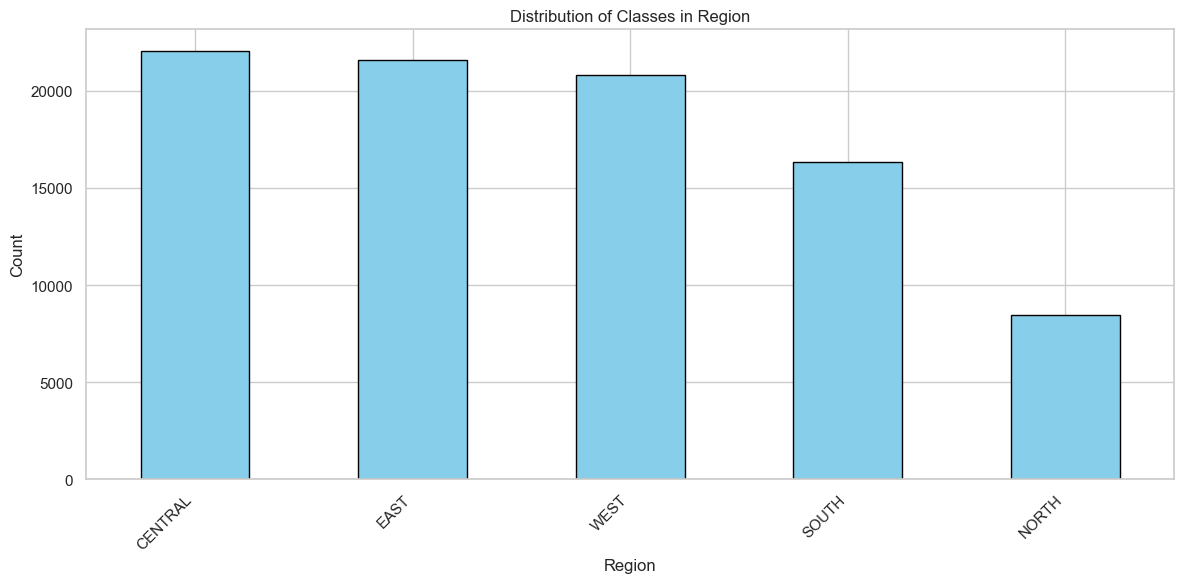

In [20]:

# Calculate the counts for each category in 'region'
region_counts = df['region'].value_counts()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
region_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Classes in Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.tight_layout()
plt.show()



### Distribution of the province regions

### 5.2) One hot encoding

Rationale: We are using SMOTE to handle imabalnced data and logistic regression for our recommendation system. Both require numerical data, hence categorical data is one hot encoded. 

In [21]:
#Number of columns before one hot encoding
print("Number of columns in the DataFrame:", df.shape[1])


Number of columns in the DataFrame: 19


In [22]:
# Identify non-numeric columns for one-hot encoding
columns_to_encode = df.select_dtypes(exclude=['number', 'bool']).columns.tolist()

# One-hot encode the categorical columns
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False)

# One-hot encode the 'region' column
if 'region' in df.columns:
    df = pd.get_dummies(df, columns=['region'], drop_first=True)
    
# Convert True/False columns to 1/0
bool_columns = df.select_dtypes(include=['bool']).columns
for col in bool_columns:
    df[col] = df[col].astype(int)

In [23]:
#Number of columns after one hot encoding
print("Number of columns in the DataFrame:", df.shape[1])

Number of columns in the DataFrame: 72


## 6) Understanding the clustering of data
This includes two parts:
1. tSNE plot to observe how distinct the customers who purchase a product are compared to the rest who do not purchase the product. This will be done for each product, in this case 4 plots.
2. Printing the proportion of people who purchase each product

### 6.1) tSNE plot

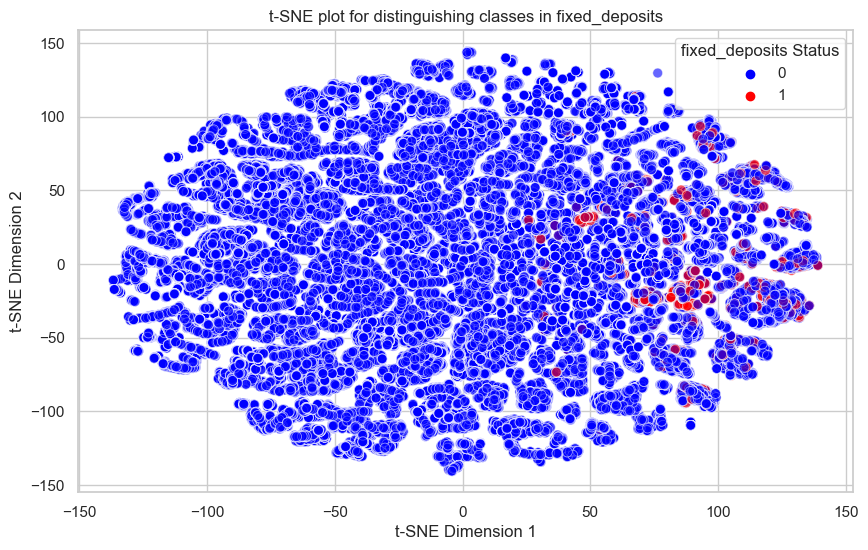


Analysis for fixed_deposits: Check if points cluster well by color (class). If yes, this may indicate important features for determining fixed_deposits.


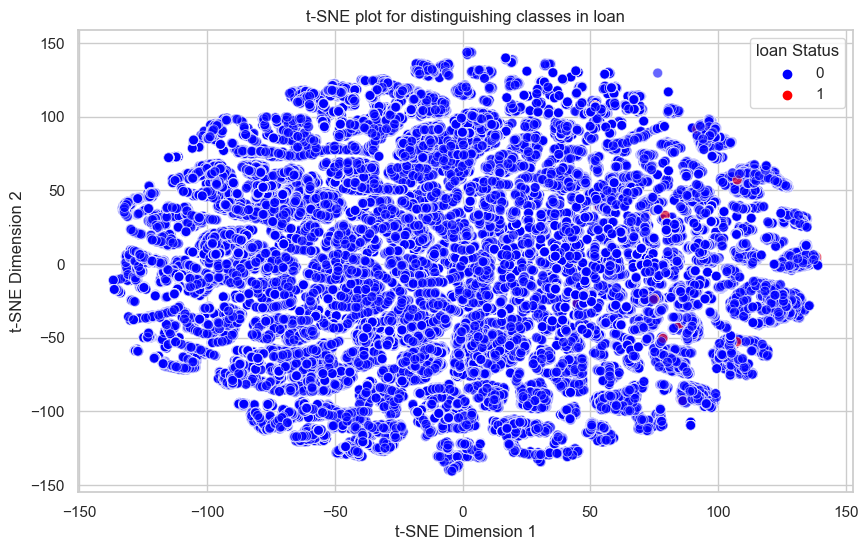


Analysis for loan: Check if points cluster well by color (class). If yes, this may indicate important features for determining loan.


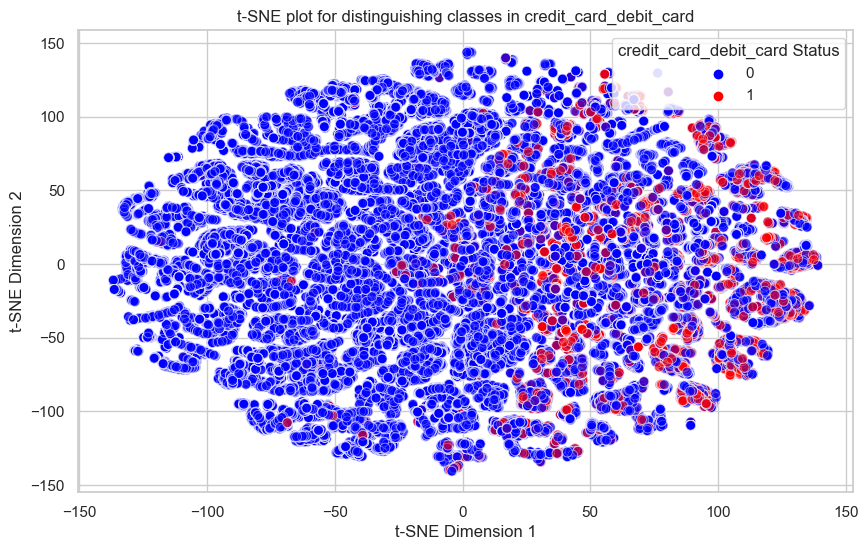


Analysis for credit_card_debit_card: Check if points cluster well by color (class). If yes, this may indicate important features for determining credit_card_debit_card.


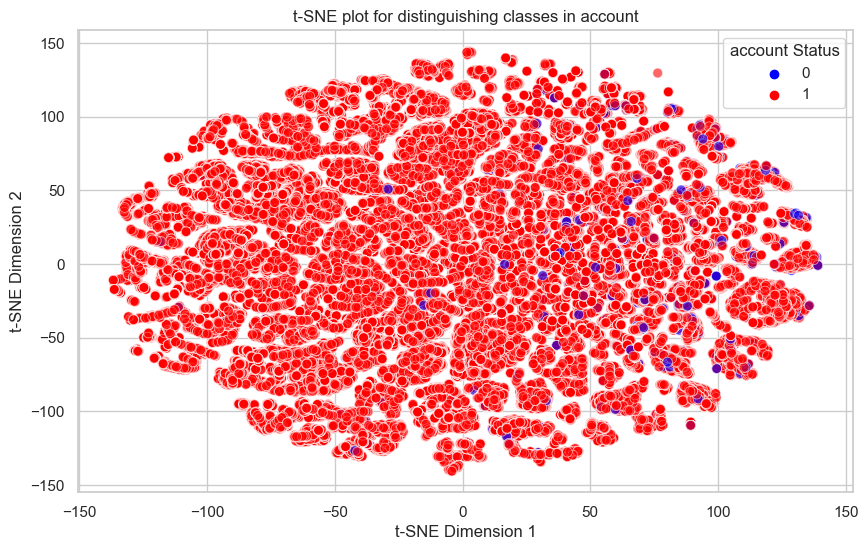


Analysis for account: Check if points cluster well by color (class). If yes, this may indicate important features for determining account.


In [24]:

# Make sure to set a random seed for reproducibility

np.random.seed(42)

# Assuming `df` is your dataset with feature columns and label columns
label_columns = ['fixed_deposits', 'loan', 'credit_card_debit_card', 'account']
feature_columns = [col for col in df.columns if col not in label_columns]

# Step 1: Preprocess the data
# Separate features and labels
X = df[feature_columns]
y = df[label_columns]

# Standardize the numerical columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply t-SNE for each label column
for label in label_columns:
    # Run t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Plot t-SNE with color representing each label's state (0 or 1)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=X_tsne[:, 0],
        y=X_tsne[:, 1],
        hue=df[label],
        palette={0: 'blue', 1: 'red'},
        alpha=0.6,
        s=50
    )
    plt.title(f't-SNE plot for distinguishing classes in {label}')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title=f'{label} Status')
    plt.grid(True)
    plt.show()

    print(f"\nAnalysis for {label}: Check if points cluster well by color (class). If yes, this may indicate important features for determining {label}.")


### 6.2) Plot to understand the proportion of people who purchase each product

In [25]:
def print_class_imbalance_tables(df):
    # List of columns to check for class imbalance
    columns_to_check = ['fixed_deposits', 'loan', 'credit_card_debit_card', 'account']
    
    # Loop through each column and calculate class imbalance
    for column in columns_to_check:
        if column in df.columns:  # Ensure the column exists in the DataFrame
            class_counts = df[column].value_counts()
            total_count = class_counts.sum()
            
            # Calculate percentages
            percentages = (class_counts / total_count) * 100
            
            # Create a DataFrame for a cleaner table display
            imbalance_df = pd.DataFrame({
                'Class': class_counts.index,
                'Counts': class_counts.values,
                'Percentage': percentages.values
            })
            
            print(f"\nClass imbalance for '{column}':")
            print(imbalance_df.to_markdown(index=False))
        else:
            print(f"\nColumn '{column}' not found in the DataFrame.")

print_class_imbalance_tables(df)


Class imbalance for 'fixed_deposits':
|   Class |   Counts |   Percentage |
|--------:|---------:|-------------:|
|       0 |    87248 |      97.7262 |
|       1 |     2030 |       2.2738 |

Class imbalance for 'loan':
|   Class |   Counts |   Percentage |
|--------:|---------:|-------------:|
|       0 |    89141 |    99.8465   |
|       1 |      137 |     0.153453 |

Class imbalance for 'credit_card_debit_card':
|   Class |   Counts |   Percentage |
|--------:|---------:|-------------:|
|       0 |    79814 |      89.3994 |
|       1 |     9464 |      10.6006 |

Class imbalance for 'account':
|   Class |   Counts |   Percentage |
|--------:|---------:|-------------:|
|       1 |    87970 |     98.5349  |
|       0 |     1308 |      1.46509 |


## 7) Checking for dataset imbalance

Checking for dataset imbalance is crucial because imbalanced datasets can bias models, favoring the majority class and leading to poor performance for the minority class. This can result in high accuracy but low recall for important but rare events like fraud detection or disease diagnosis.  

We decided to use SMOTE (Synthetic Minority Over-sampling Technique) to address this imbalance because it generates synthetic samples for the minority class, rather than duplicating existing ones. This balances the class distribution without overfitting, helping the model better capture the minority class's characteristics and improving recall.  

Other methods to handle imbalance include undersampling the majority class or using class weights. Undersampling can reduce information from the majority class, while class weighting adjusts focus during training. SMOTE is preferred here because it preserves the dataset's integrity and enhances the model's ability to learn from the minority class.  

It's important to remember that imbalance only matters for target labels, not features, as we're focused on improving classification for the imbalanced target classes.  

This section involes:
1. Splitting the data into training and testing data, SMOTE is only run on training data. This ensures that the test data remains a true representation of real-world data, reflecting the actual distribution of class labels. If SMOTE were applied to the test set, it would distort the performance evaluation by introducing synthetic data, which could lead to overly optimistic or biased results.
2. Perform SMOTE on training data and observe the distribution of target labels before and after SMOTE


### 7.1) Data splitting
Splitting the data into training and testing. Smote will only be done on training data  
In addition, the y label columns will be moved to the front for easy reference

In [26]:
# Define the target columns to move to the front
columns_to_move = ['fixed_deposits', 'loan', 'credit_card_debit_card', 'account']
# Remove the target columns from the DataFrame
remaining_columns = [col for col in df.columns if col not in columns_to_move]
# Add the target columns back to the front
df = df[columns_to_move + remaining_columns]

# Perform the 80/20 train-test split
df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Reset indices for both datasets to avoid misaligned indexing
df = df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Save the test dataset to CSV
test_df.to_csv("clean_test_reco.csv", index=False)

### 7.2) Perform SMOTE
Checking for class imbalance and resolving it with SMOTE if necessary

In [27]:
def print_class_imbalance_tables(df):
    # List of columns to check for class imbalance
    columns_to_check = ['fixed_deposits', 'loan', 'credit_card_debit_card', 'account']
    
    # Loop through each column and calculate class imbalance
    for column in columns_to_check:
        if column in df.columns:  # Ensure the column exists in the DataFrame
            class_counts = df[column].value_counts()
            total_count = class_counts.sum()
            
            # Calculate percentages
            percentages = (class_counts / total_count) * 100
            
            # Create a DataFrame for a cleaner table display
            imbalance_df = pd.DataFrame({
                'Class': class_counts.index,
                'Counts': class_counts.values,
                'Percentage': percentages.values
            })
            
            print(f"\nClass imbalance for '{column}':")
            print(imbalance_df.to_markdown(index=False))
        else:
            print(f"\nColumn '{column}' not found in the DataFrame.")

print_class_imbalance_tables(df)


Class imbalance for 'fixed_deposits':
|   Class |   Counts |   Percentage |
|--------:|---------:|-------------:|
|       0 |    69823 |     97.7612  |
|       1 |     1599 |      2.23881 |

Class imbalance for 'loan':
|   Class |   Counts |   Percentage |
|--------:|---------:|-------------:|
|       0 |    71312 |    99.846    |
|       1 |      110 |     0.154014 |

Class imbalance for 'credit_card_debit_card':
|   Class |   Counts |   Percentage |
|--------:|---------:|-------------:|
|       0 |    63837 |        89.38 |
|       1 |     7585 |        10.62 |

Class imbalance for 'account':
|   Class |   Counts |   Percentage |
|--------:|---------:|-------------:|
|       1 |    70377 |     98.5369  |
|       0 |     1045 |      1.46313 |


Evidently the target labels are very skewed and hence SMOTE is required

In [28]:
#select an equal amount of each class, and use SMOTE to balance the rest

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
# Initialize the new balanced DataFrame
balanced_df = pd.DataFrame()

# Define the label columns to balance
label_columns = ['fixed_deposits', 'loan', 'credit_card_debit_card', 'account']

# Set the maximum number of samples to take from any class
max_samples = number_of_each_class  # Adjust as needed

# Loop over each label column to balance it individually
for label in label_columns:
    # Separate the current label and the features
    y = df[label]
    X = df.drop(columns=label_columns)  # Keep all features but exclude other labels

    # Prepare the data to balance the 0 and 1 classes for the current label
    class_0 = df[df[label] == 0]
    class_1 = df[df[label] == 1]

    # Take a max of 'max_samples' or the available samples for each class
    sampled_class_0 = class_0.sample(n=min(len(class_0), max_samples), random_state=42)
    sampled_class_1 = class_1.sample(n=min(len(class_1), max_samples), random_state=42)

    # Combine the samples to form the data for SMOTE
    df_to_balance = pd.concat([sampled_class_0, sampled_class_1], ignore_index=True)

    # Separate features and the label for SMOTE
    X_balance = df_to_balance.drop(columns=label)
    y_balance = df_to_balance[label]

    # Apply SMOTE to balance the current label
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_balance, y_balance)

    # Create a DataFrame from the resampled data
    resampled_df = pd.DataFrame(X_resampled, columns=X_balance.columns)
    resampled_df[label] = y_resampled  # Add the resampled label back

    # Append the resampled data to the balanced_df
    balanced_df = pd.concat([balanced_df, resampled_df], ignore_index=True)


### Additional data cleaning steps

In [29]:
# Shuffle the final balanced DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True).head(number_of_each_class*2*len(label_columns))

# Save the updated DataFrame to a new CSV file
balanced_df.to_csv(output_file_path, index=False)

print(f"CSV file successfully relabelled and saved to {output_file_path}")

CSV file successfully relabelled and saved to data/clean_train_reco.csv


### Checking class distribution for the y values
For 4 products we have 4 binary columns that we need to balance. Each column has possible values of either 0 or 1 and hence there are 8 classes to balance, hence a 50/50 split is impossible, the best proportion is about 12.5%. Hence SMOTE is used solely to create enough samples of the minority classes to train the model.

In [30]:
print_class_imbalance_tables(balanced_df)


Class imbalance for 'fixed_deposits':
|   Class |   Counts |   Percentage |
|--------:|---------:|-------------:|
|       0 |   102680 |      85.5667 |
|       1 |    17320 |      14.4333 |

Class imbalance for 'loan':
|   Class |   Counts |   Percentage |
|--------:|---------:|-------------:|
|       0 |   104836 |      87.3633 |
|       1 |    15164 |      12.6367 |

Class imbalance for 'credit_card_debit_card':
|   Class |   Counts |   Percentage |
|--------:|---------:|-------------:|
|       0 |    91186 |      75.9883 |
|       1 |    28814 |      24.0117 |

Class imbalance for 'account':
|   Class |   Counts |   Percentage |
|--------:|---------:|-------------:|
|       1 |    96124 |      80.1033 |
|       0 |    23876 |      19.8967 |
